# Automatically Grading Alternative Text on Twitter


The increase in videos and images has lead to Twitter becoming increasingly visual, which excludes people with vision impairments from the platform. One central element to make visual content accessible is providing textual descriptions (alternative text) to user-posted images. Platforms like Facebook and Instagram have used algorithms to automatically tag pictures with low-quality descriptions; Twitter encourages users to add their own descriptions for the images they post (to do so, the user first needs to turn on [the option in accessibility setting](https://help.twitter.com/en/using-twitter/picture-descriptions), where they need to check the "Compose image descriptions" option).

![alt text](https://i.ibb.co/0MFMf8S/setting.png)

After the setting is set up, users have the option of composing image descriptions when they post an image. 

![alt text](https://i.ibb.co/4mX63Gc/submit.png)

However, efforts to increase the prevalence of alt text descriptions on social media have faltered as many users do not know how to write high-quality image descriptions. Therefore, how to evaluate the relevance and quality of alt text descriptions for images would be crucial to improving user-entered alt text.

Thus, the objective of our project is to train a classifier that automatically rates the alt text quality, to give the user feedback on their image description quality. We are going to explore how Twitter users leverage alternative text to describe the images they uploaded.

## Related Work

Alternative text, introduced in the HTML specification in 1995 [1], is read by screen readers and Braille displays when blind users encounter images on the web. Many websites do not include alt text. In 2006, only 37% of images on top websites contained alternative text [2], and last year this increased to 50% [3].

However, these numbers are different for social media platforms. Morris et al. found that Twitter was becoming more inaccessible with an increase in visual content [4]. It was originally a text-only site, which made it relatively easy to access via a screen-reader. Now, around 25% of tweets contain some media (image, video, or GIF).

Cole Gleason (one of the authors on this project) has previously conducted research in this area, and we will re-use an unprocessed dataset collected last year [5] (with no image features extracted) for this analysis. We will describe how you could replicate this step to collect a new dataset.



## Required Dependencies
To run this project, in addition to standard data science tools like numpy and pandas, you will need the following packages:

*   [scikit-learn](https://scikit-learn.org/stable/)
*   [python-twitter](https://python-twitter.readthedocs.io/en/latest/)
*   [spacy](https://spacy.io/)
*   [py-torch](https://pytorch.org/)
*   [transformers](https://pypi.org/project/transformers/)
*   [ftfy](https://pypi.org/project/ftfy/)
*   [treeinterpreter](https://github.com/andosa/treeinterpreter)

In [0]:
# use this cell to install these requirements
!pip install scikit-learn==0.22 python-twitter transformers spacy torch ftfy treeinterpreter
!pip install langdetect

     |████████████████████████████████| 7.0MB 2.8MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 368kB 52.8MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 1.0MB 43.9MB/s 
     |████████████████████████████████| 675kB 52.6MB/s 
     |████████████████████████████████| 860kB 38.2MB/s 
  Created wheel for ftfy: filename=ftfy-5.6-cp36-none-any.whl size=44553 sha256=8ed522c9d8bb948c683ac149f9abf92adca4074935e20997b8d8abc105369622
  Stored in directory: /root/.cache/pip/wheels/43/34/ce/cbb38d71543c408de56f3c5e26ce8ba495a0fa5a28eaaf1046
  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609189 sha256=240669e3ca8e8bd408ecaf4ac20bbbcaa8a2e04ed071df684a6a097ecba96253
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 s

## Overview of Analysis Pipeline
We use three information on a tweet: the post text, image, and alt text. Our analysis pipeline includes the following components:


1.   **Data Collection**: Collect tweets from Twitter.
2.   **Preprocessing**: Preprocess the collected tweets.
3. **Quality Ratings**: Rate tweets' alt text quality to create class labels.
4. **Feature Extraction**: Recognize tags and text from image. Create features from the post text, image, and alt text through NLP.
5. **Classification Model Selection and Training**: Perform model selection through cross validation.
6. **Model Parameter Tuning**: Fine tune the model parameter.
7. **Training and Evaluating the Chosen Classifier**: Train the chosen classifier. Evaluate the model with multiple metrics.
8. **Examining Misclassifications**: Examine mis-classified examples. 
9. **Using Classifier to Automatically Grade Alt Text**: Use our trained model to grade new alt text.


## Data Collection

We collect data (tweets) from Twitter using the [Twitter API](https://developer.twitter.com/en/docs), specificially by using the [python-twitter](https://python-twitter.readthedocs.io/en/latest) package.

In [0]:
# To use the Twitter API, you will need access tokens.
# Get them here: https://developer.twitter.com/en/docs/basics/authentication/guides/access-tokens
import twitter
# Store access keys in file called config.py.
from config import Config 
twitter_api = twitter.Api(consumer_key=Config.TWITTER_CONSUMER_KEY,
                  consumer_secret=Config.TWITTER_CONSUMER_SECRET,
                  access_token_key=Config.TWITTER_ACCESS_TOKEN_KEY,
                  access_token_secret=Config.TWITTER_ACCESS_TOKEN_SECRET,
                  tweet_mode='extended')

Here we demonstrate how we collect tweets randomly, or from a single account--- we use both approaches.

### Randomly Sampling Tweets

This function collects N tweets randomly:

In [0]:
def random_sample_tweets(n=100):
  """
  Pulls from a 1% sample of Twitter, and returns a list of n tweets once collected.
  """
  random_sample = []
  for tweet in twitter_api.GetStreamSample():
    status = twitter.Status.NewFromJsonDict(tweet)
    if status.user: # some of the objects returned here are delete messages, which we don't want to save
      random_sample.append(status)
      if len(random_sample) >= n:
          break
  return random_sample

random_5 = random_sample_tweets(5)
for tweet in random_5:
  if tweet.user:
    print(f"{tweet.user.screen_name} tweeted: {tweet.text}")

ssinum tweeted: RT @ghk8qwic2: 엄마 같은 스타일, 아빠 같은 스타일 https://t.co/T4ObdJN9jm
dzWHoE0zzxUt5PB tweeted: @yousuck2020 羨ましい限りてす！
1億円貰いたいです！
takara0215_s tweeted: @orikero_TL 
マリリ嬢マジで可愛すぎるな(自惚れ)
jU5JdPXTdbczWIn tweeted: RT @irasutoya: チョコチップメロンパンのイラスト https://t.co/NnrzxzEH2E
Matheus54741198 tweeted: RT @emicigg_: É ruim dms você fazer questão da pessoa e ela caga pra vc e vc vê ela fazendo questão de outras pessoas  kkkk


### Retrieving Tweets from a Specific User

We can also collect tweets from a specific user. This function collects N tweets given a specific username, or all avalable tweets if None is given.

In [0]:
def get_user_tweets(screenname, n=100):
  # if None is passed as the count parameter, we will retrieve all available tweets
  if n == None:
    remaining = 200
  else:
    remaining = n
  max_id = None
  rv = []
  while remaining > 0:
    tweets = twitter_api.GetUserTimeline(screen_name=screenname, count=remaining,
                                    exclude_replies=True, max_id=max_id)
    if len(tweets) == 0:
      break
    if n:
      remaining -= len(tweets)
    rv.extend(tweets)
    max_id = tweets[-1].id_str
  return rv

In [0]:
# By passing None we will get all available tweets.
tweets = get_user_tweets('SCSatCMU', n=None)
print(f"Collected {len(tweets)} tweets.")
print("Oldest tweet found: ", tweets[-1].full_text)

Collected 3250 tweets.
Oldest tweet found:  Carnegie Mellon @nrec_cmu CHIMP robot will make rare appearance @projectolympus Show&amp;Tell Apr 14 https://t.co/NwjQbGdMwM


## Descriptive Statistics of Dataset and Preprocessing
The dataset was collected in June 2018, and consists of tweets sampled over 5 days \[5\]. Of 9.22M tweets sampled, 1.09M contained images.

In [0]:
# load dataset, extract alt text tweets
import json
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set()
%matplotlib inline

In [0]:
# We collected 6 batches of data and named them as 1-6
# We load them the following way
twitter_count = 0
alt_text = []
for x in range(1,6):
    with open("tweets_"+ str(x) + ".txt") as myfile:
        head = myfile.readlines()
        twitter_count = twitter_count + len(head)
        for h in range(len(head)):
            t = json.loads(head[h][:-1])
            try:
                atl = t["extended_entities"]['media'][0]['ext_alt_text']  #get alt_tags
                if atl != None:
                    alt_text = alt_text + [t]
            except:
                pass

# This piece of code is just for demonatration purpose as we are not goinig to include these files on the fly.
# Our local version printed out:
# The number of Tweets we have collected: 1091875

In [0]:
#After the previous step, we have obtained a pickle file contained all Tweets that contained alt_tags
import pickle
alt_text = pickle.load( open( "alt_text_final.p", "rb" ) )

In [0]:
# the length of alt text without any filtering
len(alt_text)

1143

In [0]:
# We can print them out to have an impression about what the alt_texts are about
for x in range (0,20):
    print (alt_text[x]['extended_entities']['media'][0]['ext_alt_text'])

https://www.flickr.com/photos/maevalecoq/
Suruç’da hastanede kameralar tahrip edilmiş, saldırı planlı görünüyor!
http://contemporary-art-blog.tumblr.com/post/21933515681
Image
http://www.designboom.com/architecture/moon-hoon-interview-10-24-2014/
Obama, Luis and your friend Lin
http://archillect.com
北と南の方角を示すイラスト。真ん中に十字模様があり、北にホッキョクグマ、南にペンギンが描かれている。
http://an-addled-mind.tumblr.com/post/99323224073
Girl posing In front of the blue YSL majorelle house in Morocco with a straw hat on
http://archillect.com
http://archillect.com
Obama, Luis and your friend Lin
https://www.flickr.com/photos/maevalecoq/
Tony Hawk's Existential Nightmare (PS2, 2018)
http://archillect.com
Obama, Luis and your friend Lin
“How to talk to the landlord:” left: says “no” above a happy landlord talking to a single tenant right: says “yes” above a sad landlord talking to a group of tenants
Imagem de pinos usados para colocar cocaína decorados com bandeiras de alguns dos países participantes da Copa do Mundo de 2018
Ob

There are many URLs from flicker, tumblr or archilletct, and non-English words, which we remove.

In [0]:
#We define a helper method to help us filter out the urls 
def find_url(string): 
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string) 
    return url

In [0]:
alt_filter_url = []

for a in alt_text:
    atl = a["extended_entities"]['media'][0]['ext_alt_text'] 
    if find_url(atl) == []:
        alt_filter_url = alt_filter_url + [a]
print("Number of alt_tags after filtrering out URLs:", len(alt_filter_url))

Number of alt_tags after filtrering out URLs: 505


In [0]:
#We then use a module called langdetect to detect English Tweets

from langdetect import detect

alt_filter_english = []

for a in alt_filter_url:
    atl = a["extended_entities"]['media'][0]['ext_alt_text'] 
    try:
        if detect(atl) == 'en':
            alt_filter_english = alt_filter_english + [a]
    except:
        pass
print("Number of alt_tags after filtrering out URLs and non-English Tweets :", len(alt_filter_english))

Number of alt_tags after filtrering out URLs and non-English Tweets : 315


In [0]:
# We tried to see the distribution of these posts. 

from collections import Counter

alt_user = []
for a in alt_filter_english:
    alt_user = [a['user']['id']] + alt_user
unique_alt_user =  list((set(alt_user)))
dict_count = dict.fromkeys(unique_alt_user,0)
for a in alt_filter_english:
    user_id = a['user']['id']
    dict_count[user_id] = dict_count[user_id] + 1
Counter(dict_count.values())

#Most users only post one Tweeet that contains Atl-tags.

Counter({1: 278, 2: 4, 3: 1, 4: 3, 7: 2})

In [0]:
# We then check their numbere of followers 
follower_count = []
for a in alt_filter_english:
    follower_count = follower_count + [a['user']['followers_count']]
follower_count.sort()

In [0]:
id_follower = []
processed_id = []
for a in alt_filter_english:
    follower = a['user']['followers_count']
    user_name = a['user']['screen_name']
    user_id = a['user']['id']
    status_count = a['user']['statuses_count']
    if user_id not in processed_id:
            processed_id = [user_id] + processed_id    
            id_follower = id_follower + [[user_name,user_id,follower,status_count]]

In [0]:
df = pd.DataFrame(data=id_follower)
df.columns =['user_name', 'user_id','num_of_followers','status_count'] 

In [0]:
# Show users with Top 10 # of followers 
df.sort_values(by=['num_of_followers'],ascending=False).head(10)

,user_name,user_id,num_of_followers,status_count
140,SmarterTravel,14132853,311978,32597
211,MisfitsGG,3182089458,59583,6939
177,netstartraffic,74991659,34364,209886
151,robpegoraro,7301572,18255,44570
175,Meeea,271081057,12488,128948
176,MatthewOldridge,519071841,10051,43019
194,Iheartnoise,15273924,8482,237793
266,unchangingglow,148481078,7984,211486
31,TerryHa32444924,810654457096785900,7838,50283
9,BrittSabo,238867685,7385,77911


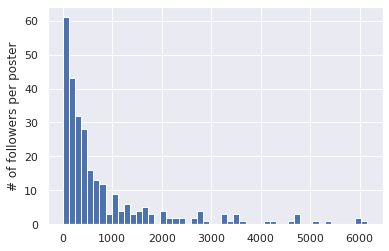

In [0]:
# a distribution of number of followers for alt-tag posters.
# It seems that the usage of alt tags is not related with # of followers
follower_list = list(df.num_of_followers)
follower_list.sort()
plt.hist(follower_list[:-10], bins=50)
plt.ylabel('# of followers per poster');

In [0]:
df.sort_values(by=['status_count'],ascending=False).head(10)

,user_name,user_id,num_of_followers,status_count
49,linkfinds,745712201093255200,3516,276064
5,Shasta_Otter,155477349,1559,274110
184,petermccue1,394093191,2738,250027
45,PiifernloveSJ,171407805,416,246317
120,MrSinister53,1475168784,4630,242620
194,Iheartnoise,15273924,8482,237793
266,unchangingglow,148481078,7984,211486
154,lilstur,1197589765,2174,210482
177,netstartraffic,74991659,34364,209886
222,HeatherSchultz,22029173,1509,207760


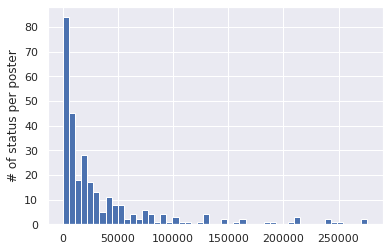

In [0]:
status_count_list = list(df.status_count)
status_count_list.sort()
plt.hist(status_count_list, bins=50)
plt.ylabel('# of status per poster');

In [0]:
# are they verified

verified_count = 0
for u in range(len(alt_filter_english)):
    if alt_filter_english[u]['user']['verified'] == True:
        verified_count = verified_count +1
        
print(verified_count, "users are verified Twitter users.")

4 users are verified Twitter users.


## Quality Ratings

We load a subset of the collected dataset, with quality ratings from 0 (Irrelevant) to 3 (Great).

0.   Irrelevant: the alt text is unrelated to the image (often like "image")
1.   Somewhat relevant: the alt text is related to image but not descriptive. For example, it might just say "dog".
2.   Good: One or more of actors, actions, and setting are described well in the image. Perhaps "bob, our golden retriever"
3.   Great: All of actors, actions, and setting are described well. For example, "Our golden retriever Bob is midair as he catches a frisbee in the field behind our house"

Full rubric [here](https://drive.google.com/file/d/1ggNGhZwzBviz417MZH5GbV2BanYjwgmQ/view?usp=sharing).

In [0]:
df = pd.read_csv('hand_rated_alt_text.csv', dtype=str)
df.set_index(['tweet_id', 'image_index'], inplace=True) # a tweet can have more than one image
df['post_text'].fillna('', inplace=True) # tweets don't need to have post text, so let's treat these as empty strings
df = df[df.quality_rating.notnull()] # a few are unrated. we will remove them.
df.alt_text = df.alt_text.astype("str") # ensure all alt text has string datatype
df.quality_rating = df.quality_rating.astype("int") # treat the quality rating as an integer, not a float.
cat_dtype = pd.api.types.CategoricalDtype(categories=[0,1,2,3], ordered=True) # now change it to a categorical type
df.quality_rating = df.quality_rating.astype(cat_dtype)
df

,,sample_name,author_screenname,author_userid,post_text,image_url,alt_text,quality_rating
tweet_id,image_index,,,,,,,
1006853723027640321,0,initial_94,SmarterTravel,14132853,Seven ultra-useful carry-on bags: https://t.co...,http://pbs.twimg.com/media/DfkQH34UcAE86J6.jpg,Woman with carry-on,2
1006727264762060802,0,initial_94,endless_lands,739933308365111298,Unfinished Mountain Principality https://t.co/...,http://pbs.twimg.com/media/DfidHJbX4AA-tRf.jpg,Unfinished Mountain Principality,1
1006732469897269249,0,initial_94,robpegoraro,7301572,Mr. @tynanwrites makes a friend at #CESAsia. h...,http://pbs.twimg.com/media/DfihrWJX4AAYXZW.jpg,Dan greets a robot carrying a tray of mints.,2
1006722718111289344,0,initial_94,CarRegNG,817038404311465984,Requirements to Pass VIO Computerized Road Wor...,http://pbs.twimg.com/media/DfiY-gBW0AA8NO7.jpg,New Vehicle Reg | Change of ownership | Paper ...,0
1006826871089221633,0,initial_94,dmartw,148753316,What's this about a #raccoon climbing a skyscr...,http://pbs.twimg.com/media/Dfj3s8UWsAEk1iq.jpg,Eric Cartman from South Park dressed as The Co...,3
...,...,...,...,...,...,...,...,...
1016686645523853312,0,sample_3_no_bots,mylittlefinger,17963349,Two Green bee-eaters https://t.co/93L57wcAau,http://pbs.twimg.com/media/Dhv_DOPU8AEt0p9.jpg,Green bee-eaters,2
1007654729835601922,0,sample_3_no_bots,SmarterTravel,14132853,"A1: Beaches, of course! Some of our favorites ...",http://pbs.twimg.com/media/DfvoosQWAAIWvha.jpg,Beach sunset,2
991652298731479040,0,sample_3_no_bots,SmarterTravel,14132853,10 insanely affordable spring vacations you ca...,http://pbs.twimg.com/media/DcMOgmxW4AE6obq.jpg,Colorful Curacao,2


In [0]:
# Some of the rows are missing metadata (author, post text). 
# Let's fill those in using the twitter API.

# select tweets missing author information
missing_metadata = df[df['author_userid'].isna()]
tweet_ids = missing_metadata.index.get_level_values(0).tolist()
# get tweets from twitter api
result = twitter_api.GetStatuses(tweet_ids, map=True)
# create a new data frame from this data
data = [(id,0,t.user.id_str,t.user.screen_name, t.text) for id,t in result.items() if t]
df2 = pd.DataFrame(data, columns = ['tweet_id', 'image_index', 'author_userid', 'author_screenname', 'post_text'])
df2.set_index(['tweet_id', 'image_index'], inplace=True)
# update rows of original dataframe with new data
df.update(df2)

In [0]:
# drop rows that start with urls
url = df['alt_text'].map(lambda x: x.startswith('http://') or x.startswith('https://') if type(x) == str else False)
df = df[~url]

Total remaining examples: 1980


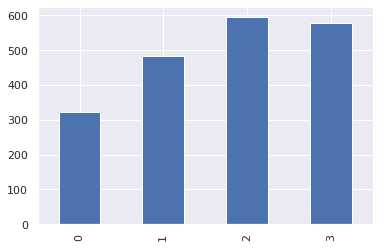

In [0]:
# Let's see a distribution of the ratings.
print(f"Total remaining examples: {len(df)}")
df.quality_rating.value_counts(sort=False).plot(kind='bar');

The above plot shows rating distributions.

## Feature Extraction
Our goal is to create a classifier that can distinguish good from bad alt text. We use the post text, image, and alt text to create features.

### Alt Text Perplexity
Some people use alt text for search engine optimization. To penalize this, we measure perplexity using the GPT language model. When alt text is well-structured and probable, perplexity will be low.

In [0]:
import math
import random
import torch
from transformers import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel
# Load pre-trained language model 
model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
model.eval()
# Load pre-trained model tokenizer
tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
def gpt_perplexity(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    # Because of how this GPT model is trained, the perplexity is not defined for documents with only one word. 
    # So we will set one-word alt text to have a perplexity of None for now, and we can address that later.
    if len(tokenize_input) < 2:
      return None
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss, logit = model(tensor_input, labels=tensor_input)
    return math.exp(loss)

100%|██████████| 458495/458495 [00:00<00:00, 516911.09B/s]


In [0]:
# Now we compute perplexisty for our dataset, saving to disk to save time later on.
import os
if not os.path.exists('perplexity.csv'):
  df['perplexity'] = df.apply(lambda r: gpt_perplexity(r.alt_text), axis=1)
  # save to file as it takes a while to compute
  df['perplexity'].to_csv('perplexity.csv', header=True)
else:
  perp_df = pd.read_csv('perplexity.csv', header=0, dtype='str')
  perp_df.set_index(['tweet_id', 'image_index'], inplace=True) # a tweet can have more than one image
  df['perplexity'] = perp_df['perplexity'].astype("float")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Tags Describing Images
We use the [Microsoft Cognitive Services API](https://azure.microsoft.com/en-us/services/cognitive-services/computer-vision/) to generate tags and recognize text from an image.

Given the image URL, the tags of an image are recognized as a “bag of words”, including objects, scenes, and colors of the image.

In [0]:
import requests
from IPython.display import Image
from IPython.core.display import HTML 

def get_tags_and_objects(image_url):
    """Provides a caption given an image. Also includes tags, colors, dimensions, and confidence level."""
    analyze_url = "https://eastus.api.cognitive.microsoft.com/vision/v2.0/analyze"
    headers = {'Ocp-Apim-Subscription-Key': Config.msft_subscription_key}
    params = {'visualFeatures': 'Objects,Tags,Description'}
    data = {'url': image_url}
    response = requests.post(analyze_url, headers=headers,
                             params=params, json=data)
    try:
        response.raise_for_status()
    except:
        print(f"ERROR: {response.content}")
        return None
    analysis = response.json()
    rv = set(analysis["description"]['tags'])
    rv.update([o["object"] for o in analysis['objects']])
    return ' '.join(rv)

image_url = df['image_url'][0]
print(f"Tags for first image: {get_tags_and_objects(image_url)}")
Image(url=image_url,width=400)

Tags for first image: city talking holding suitcase red girl building cellphone suit phone bag Luggage and bags outdoor lady standing person sidewalk luggage meter dog man wearing blue carrying woman black walking young street


### Text in Images

Some images contain text, which should be in the alt text as well to be a good description. We use text recognition to extract these text.

In [0]:
def get_text_in_image(image_url):
    """Provides a caption given an image. Also includes tags, colors, dimensions, and confidence level."""
    analyze_url = "https://eastus.api.cognitive.microsoft.com/vision/v2.0/ocr"
    headers = {'Ocp-Apim-Subscription-Key': Config.msft_subscription_key}
    params = {}
    data = {'url': image_url}
    response = requests.post(analyze_url, headers=headers,
                             params=params, json=data)
    try:
        response.raise_for_status()
    except:
        print(f"ERROR: {response.content}")
        return None
    analysis = response.json()
    words = [w['text'] for r in analysis['regions'] for l in r['lines'] for w in l['words']]
    return ' '.join(words)
  
image_url = 'http://pbs.twimg.com/media/DgMjXuUUwAE8_dn.jpg'
print(f"Text for image: {get_text_in_image(image_url)}")
Image(url=image_url,width=400)

Text for image: CarReg.com.ng 090 9014 4706 New Vehicle Registration, Change of ownership & Vehicle particulars renewal @CarRegNG + Home Delivery


Let's use the above functions to get the tags and text for each image and combine them with the quality rating dataset:

In [0]:
# get tags and text for our datset

import csv
headers = ['tweet_id', 'image_url', 'text', 'tags']

try:
    with open('image_text_and_tags.csv', 'r') as infile:
        reader = csv.reader(infile)
        next(reader)
        results = {r[1]:r for r in reader}
except:
    results = {}
    
for idx,r in df.iterrows():
    if r.image_url in results:
        continue
    tags = get_tags_and_objects(r.image_url)
    if tags == None:
        tags = ""
    else:
        tags = " ".join(tags)
    text = get_text_in_image(r.image_url)
    results[r.image_url] = (r.tweet_id, r.image_url, text, tags)
    with open('image_text_and_tags.csv', 'w') as infile:
        writer = csv.writer(infile)
        writer.writerow(headers)
        writer.writerows(results.values())

In [0]:
# Now that the image tags and text are extracted and saved, 
# we will load it from disk and combine it with the quality rating data.

import numpy as np
image_tags_df = pd.read_csv('image_text_and_tags.csv')
image_tags_df.set_index('image_url', inplace=True)
image_tags_df.drop(['tweet_id'], axis=1, inplace=True)
image_tags_df.fillna('', inplace=True)
df_w_text = df.join(image_tags_df, on=['image_url'])
df_w_text['text_and_tags'] = df_w_text[['text', 'tags']].apply(lambda x: ' '.join(x), axis=1)
# df_w_text.drop(['text','tags'], axis=1, inplace=True)
df_w_text.replace('', np.nan, inplace=True)
df_w_text.dropna(subset=['text_and_tags', 'alt_text', 'post_text'], inplace=True)
df_w_text['text'] = df_w_text['text'].fillna('')
df_w_text['tags'] = df_w_text['tags'].fillna('')
df_w_text

,,sample_name,author_screenname,author_userid,post_text,image_url,alt_text,quality_rating,perplexity,text,tags,text_and_tags
tweet_id,image_index,,,,,,,,,,,
1006853723027640321,0,initial_94,SmarterTravel,14132853,Seven ultra-useful carry-on bags: https://t.co...,http://pbs.twimg.com/media/DfkQH34UcAE86J6.jpg,Woman with carry-on,2,82.400070,,lady woman suitcase street red building city w...,lady woman suitcase street red building city ...
1006727264762060802,0,initial_94,endless_lands,739933308365111298,Unfinished Mountain Principality https://t.co/...,http://pbs.twimg.com/media/DfidHJbX4AA-tRf.jpg,Unfinished Mountain Principality,1,407.760973,ulinter's șpire,text clock,ulinter's șpire text clock
1006732469897269249,0,initial_94,robpegoraro,7301572,Mr. @tynanwrites makes a friend at #CESAsia. h...,http://pbs.twimg.com/media/DfihrWJX4AAYXZW.jpg,Dan greets a robot carrying a tray of mints.,2,160.495691,,building standing young suit man woman people ...,building standing young suit man woman people...
1006722718111289344,0,initial_94,CarRegNG,817038404311465984,Requirements to Pass VIO Computerized Road Wor...,http://pbs.twimg.com/media/DfiY-gBW0AA8NO7.jpg,New Vehicle Reg | Change of ownership | Paper ...,0,259.129327,LAGOS STATE GOVERNMENT MINISTRY OF TRANSPORTAT...,drawing,LAGOS STATE GOVERNMENT MINISTRY OF TRANSPORTAT...
1006826871089221633,0,initial_94,dmartw,148753316,What's this about a #raccoon climbing a skyscr...,http://pbs.twimg.com/media/Dfj3s8UWsAEk1iq.jpg,Eric Cartman from South Park dressed as The Co...,3,242.611702,,toy drawing doll,toy drawing doll
...,...,...,...,...,...,...,...,...,...,...,...,...
1016686645523853312,0,sample_3_no_bots,mylittlefinger,17963349,Two Green bee-eaters https://t.co/93L57wcAau,http://pbs.twimg.com/media/Dhv_DOPU8AEt0p9.jpg,Green bee-eaters,2,377.932553,,,
1007654729835601922,0,sample_3_no_bots,SmarterTravel,14132853,"A1: Beaches, of course! Some of our favorites ...",http://pbs.twimg.com/media/DfvoosQWAAIWvha.jpg,Beach sunset,2,153172.730017,,sand track water ocean sunset nature body boat...,sand track water ocean sunset nature body boa...
991652298731479040,0,sample_3_no_bots,SmarterTravel,14132853,10 insanely affordable spring vacations you ca...,http://pbs.twimg.com/media/DcMOgmxW4AE6obq.jpg,Colorful Curacao,2,222.877739,Lüiiii,docked bridge harbor water people boat small l...,Lüiiii docked bridge harbor water people boat ...


### NLP: Text Similarity, Parts and Length of Alt Text 

From the image, alt text, and post text, we extract the following 10 features to be used by the classifier:

1.       Cosine similarity between image tags and alt text

2.       Similarity between post text and alt text

3.       Similarity between text in image and alt text

4.       (# of verbs) / (# of words) in alt text

5.       (# of adjs) / (# of words) in alt text

6.       (# of nouns) / (# of words) in alt text

7.       Number of words in alt text

8.       Number of characters in alt text

9. Perplexity of alt text returned by GPT language model.

10. Whether or not text is present in image.

For each sample, we construct a corpus from its image tags, alt text, post text, and text in image to perform NLP.

For feature 1, we first perform vectorization using term frequency (*tf*) for each corpus while removing stop words. Each corpus is for one sample and contains four strings: alt text, image tags, post text, and text in image (if there is no text in image, it is an empty string). URLs and unicode are removed from the corpus before vectorization. We then compute this cosine similarity using the *tf* vectors of alt text and image tags for each sample.

We decided to use term frequency (*tf*) instead of *tfidf*. This is because we do not want to lower the weights of more frequently occurring words in this small corpus, since we actually want to see the same words occurring across the alt text and image tags, or across the alt text and post text. Since we filter out stop words when performing tokenization, we do not have to rely on *idf* to take care of frequently used words in English.

For features 2 and 3, we use the spacy package to compute the document similarities between the post text and alt text, and between the text in image and alt text. Spacy computes similarity based on word embeddings, which is useful as people may describe objects with different names. For example, spacy represents "cat" and "pet" as fairly similar.

However, for feature 1 we decided to use cosine similarity of *tf* vectors instead of spacy document similarity, since image tags are a set of independent words with no sentence structure or meaningful order. From our experiments, we found cosine similarity of *tf* vectors is more suitable for comparing image tags with alt text than spacy document similarity.

For features 4, 5, and 6, we use the spacy package to calculate the verb, adjective, and noun counts in alt text.

Feature 10 is a binary feature indicating if there is any text in the image. The alt text and image text similarity (feature 3) can be 0 for two cases: (1) there is text in image which is completely dissimilar to alt text, or (2) there is no text in image. In case 2, we do not want the classifier to mis-think the alt text did not do a good job to capture the text in image, so we use feature 10 to help the classifier distinguish between these two cases.

We scale the values of features 6, 7, and 8 into the range of 0-1.  This is because the other features are all within the range of 0-1. To avoid the imbalance of features’ values which could cause problems in training the classifier, we perform this scaling.


In [0]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import spacy
from collections import Counter
from sklearn import preprocessing

import spacy.cli
spacy.cli.download("en_core_web_lg")

In [0]:
def vectorize_text_tfidf(corpus):

    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(corpus)

    tokens = vectorizer.get_feature_names()

    return X, tokens

def vectorize_text_tf(corpus):
    
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(corpus)
    
    tokens = vectorizer.get_feature_names()
    
    return X, tokens

def create_features(alt_text, image_words_text, post_text, image_ocr, perplexity, scaler=None):
    
    nlp = spacy.load("en_core_web_lg")
    n_samples = len(alt_text)
    features_list = []
    
    # form a corpus for each image-alt_text pair
    for i in range(n_samples):
        raw_corpus = [alt_text[i], image_words_text[i], post_text[i], image_ocr[i]]
        
        # for each doc string in raw_corpus, filter out unicode and URL
        corpus = []
        for corpus_str in raw_corpus:
            if not corpus_str:
              corpus.append('')
              continue
            stripunicode = re.sub(r"[^\x00-\x7f]",r" ", corpus_str)
            removeURL = re.sub(r"https://\S+/[A-Za-z0-9]{10}", " ", stripunicode)
            removeURL1 = re.sub(r"http://\S+/[A-Za-z0-9]{10}", " ", removeURL)
            corpus.append(removeURL1)
        
        # get tf sparse matrix and tokens list
        X, tokens = vectorize_text_tf(corpus)
        alt_doc = nlp(corpus[0])
        img_tags_doc = nlp(corpus[1])
        post_doc = nlp(corpus[2])
        image_text_doc =  nlp(corpus[3])

        # compute cosine similarities
        alt_image_similarity = cosine_similarity(X[0,:], X[1,:])[0,0]
        alt_post_similarity = 0
        alt_ocr_similarity = 0
        if alt_doc.vector_norm:
          alt_post_similarity = alt_doc.similarity(post_doc) if post_doc.vector_norm else 0
          alt_ocr_similarity = alt_doc.similarity(image_text_doc) if image_text_doc.vector_norm else 0

        # get verbs, adjs, nouns, word_count, char_count of alt text
        word_list = corpus[0].split()
        word_count = len(word_list)
        text_in_img_bin = 1 if (len(corpus[3]) > 0) and (not corpus[3].isspace()) else 0
        doc = nlp(corpus[0])
        c = Counter([token.pos_ for token in doc])
        verbs = c['VERB']/word_count
        adjs = c['ADJ']/word_count
        nouns = c['NOUN']/word_count
        char_count = len(''.join(word_list))
        features_list.append(np.array([alt_image_similarity, alt_post_similarity, alt_ocr_similarity, verbs, adjs, nouns, word_count, char_count, perplexity[i], text_in_img_bin]))
        
    # scaling the word_count, char_count, and perplexity to the range of 0-1
    features_array = np.array(features_list)
    if not scaler:
      scaler = preprocessing.MinMaxScaler()
      scaler.fit(features_array[:,[6,7,8]])
    X_train_minmax = scaler.transform(features_array[:,[6,7,8]])
    features_array[:,[6,7,8]] = X_train_minmax
    
    return features_array, scaler


    

In [0]:
# load alt text, post text, and image words and text
alt_text = df_w_text['alt_text']
image_words_text = df_w_text['tags']
post_text = df_w_text['post_text']
image_ocr = df_w_text['text']

# if any have perplexity = None, we will set that to the highest perplexity now,
# as 1-word alt text is not a good example of well-structured sentances,
# which is essentially what we are attempting to measure here.
perplexity = df_w_text['perplexity'].fillna(np.max(df_w_text['perplexity']))

# create features, saving the min-max scaler in case we want to scale future examples
idx_array = df_w_text.index.to_list() # to keep track of samples later
features_array, scaler = create_features(alt_text, image_words_text, post_text, image_ocr, perplexity)
    
# save features array to disk so they can be easily reloaded.
np.savetxt('features.txt', features_array, fmt="%.14f")
np.savetxt('labels_multiclass.txt', df_w_text['quality_rating'], fmt="%d")

## Classification Model Selection and Training

We designed five classification models to perform model selection: Logistic Regression, SVM (linear kernel), SVM (poly kernel), SVM (rbf kernel), and Random Forest. The first two are linear classifiers while the last three are non-linear, since we want to try both linear and non-linear models. Our classifier is a multi-class classifier with four class labels (0, 1, 2, 3), each corresponding to a quality rating of alt text.

We first split our dataset into a train set and a test set in a 4:1 ratio with random shuffling. We perform 5-fold cross validation for the five models, and compare the average CV accuracy to select the model with the highest CV accuracy.

For Logistic Regression, since we are dealing with a multiclass problem, we choose the ‘lbfgs’ solver to handle multinomial loss.

For SVM, we use linear, poly, and rbf kernels for three SVM models respectively. For poly kernel, we use the default degree 3. We set the kernel coefficient gamma to 'auto', which uses 1/n_features.

For Random Forest, we use the number of trees (n_estimators) 100, for model selection.


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, cohen_kappa_score

In [0]:
def logistic_regression():
    
    logreg = LogisticRegression(
        random_state=0,
        solver='lbfgs',
        multi_class='multinomial')
    
    return logreg
    
def logistic_regression_fit(X, y):
    
    logreg = logistic_regression()
    
    logreg.fit(X, y)
    
    return logreg

def support_vector(kernel):
    # kernel: 'linear', 'poly', or 'rbf'
    # use default degree for 'poly' kernel: (default=3)
    
    svc = SVC(random_state=0, gamma='auto', kernel=kernel)
    
    return svc

def support_vector_fit(X, y, kernel):
    
    svc = support_vector(kernel)
    
    svc.fit(X, y)
    
    return svc

def random_forest(n_estimators):

    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)

    return rf

def random_forest_fit(X, y, n_estimators):

    rf = random_forest(n_estimators)

    rf.fit(X, y)

    return rf

def cross_validation(estimator, X, y, cv):
    
    scores = cross_validate(estimator, X, y, cv=cv, scoring='accuracy')
    
    return scores['test_score']
    

In [0]:
# load features and labels into np.array
X = np.loadtxt("features.txt")
y = np.loadtxt("labels_multiclass.txt")
print("X shape:", X.shape)
print("y shape:", y.shape)
    
# split train set and test set
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx_array, test_size=0.2, random_state=42)

# set up 5 models
models = {
    'Logistic Regression': logistic_regression(),
    'SVC (linear kernel)': support_vector('linear'),
    'SVC (poly kernel)': support_vector('poly'),
    'SVC (rbf kernel)': support_vector('rbf'),
    'Random Forest': random_forest(100)
}

for name, estimator in models.items():
  # perform k-fold cross validation for each model
  cv_accuracy = cross_validation(estimator, X_train, y_train, 5)
  print(f"{name}: CV average accuracy =", np.mean(cv_accuracy), "; CV fold's accuracy:", cv_accuracy)

X shape: (1932, 10)
y shape: (1932,)
Logistic Regression: CV average accuracy = 0.5799352750809061 ; CV fold's accuracy: [0.59546926 0.60841424 0.56634304 0.55339806 0.57605178]
SVC (linear kernel): CV average accuracy = 0.5838187702265373 ; CV fold's accuracy: [0.61488673 0.60517799 0.5631068  0.5631068  0.57281553]
SVC (poly kernel): CV average accuracy = 0.29514563106796116 ; CV fold's accuracy: [0.29449838 0.29449838 0.29449838 0.29449838 0.29773463]
SVC (rbf kernel): CV average accuracy = 0.5676375404530745 ; CV fold's accuracy: [0.60841424 0.5566343  0.55339806 0.5631068  0.5566343 ]
Random Forest: CV average accuracy = 0.743042071197411 ; CV fold's accuracy: [0.76699029 0.7605178  0.73139159 0.76375405 0.69255663]


| Model | Logistic Regression | SVM (linear kernel) | SVM (poly kernel) | SVM (rbf kernel) | Random Forest |
| --- | --- | --- | --- | --- | --- |
| CV Accuracy | 58.0% | 58.4% | 29.5% | 56.8% | **74.3%** |

We can see the ensemble, non-linear model Random Forest performed the best. Thus, we chose Random Forest as our classifier. SVM (poly) performed the worst. Other three models' CV accuracy are substantially lower than Random Forest’s. 

## Model Parameter Tuning

We now further tune the Random Forest parameter  n_estimators. We perform cross validation for a range of n_estimators: 60-200, and compare their CV accuracy. 

n_estimators 	 CV average accuracy 	 test accuracy
60 		 0.7391585760517799 	 0.7390180878552972
65 		 0.7385113268608415 	 0.7390180878552972
70 		 0.7423948220064724 	 0.7493540051679587
75 		 0.7404530744336569 	 0.751937984496124
80 		 0.7398058252427184 	 0.7493540051679587
85 		 0.7411003236245954 	 0.751937984496124
90 		 0.7411003236245954 	 0.7493540051679587
95 		 0.7436893203883495 	 0.7493540051679587
100 		 0.743042071197411 	 0.7545219638242894
105 		 0.7443365695792881 	 0.7467700258397932
110 		 0.7404530744336569 	 0.751937984496124
115 		 0.7475728155339806 	 0.751937984496124
120 		 0.7469255663430421 	 0.7545219638242894
125 		 0.748220064724919 	 0.7493540051679587
130 		 0.7462783171521036 	 0.7493540051679587
135 		 0.7436893203883496 	 0.7467700258397932
140 		 0.741747572815534 	 0.7467700258397932
145 		 0.7423948220064724 	 0.7493540051679587
150 		 0.741747572815534 	 0.7493540051679587
155 		 0.7423948220064724 	 0.7467700258397932
160 		 0.7443365695792881

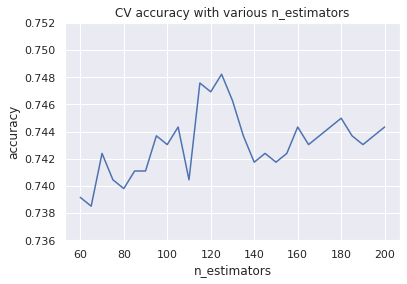

In [0]:
# perform cross validation for a range of n_estimators: 60-200
esitmator_values = []
cv_values = []
print("n_estimators \t CV average accuracy \t test accuracy")

for n_estimators in range(60, 201, 5):
    # perform k-fold cross validation for Random Forest model
    estimator = random_forest(n_estimators)
    cv_accuracy = cross_validation(estimator, X_train, y_train, 5)

    # train the Random Forest model using the train set
    clf5 = random_forest_fit(X_train, y_train, n_estimators)

    # evaluate the Random Forest model using the test set
    y_pred = clf5.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(n_estimators, "\t\t", np.mean(cv_accuracy), "\t", test_accuracy)

    esitmator_values.append(n_estimators)
    cv_values.append(np.mean(cv_accuracy))

plt.figure()
plt.plot(esitmator_values, cv_values)
plt.ylim(0.736, 0.752)
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.title("CV accuracy with various n_estimators")

plt.show()


In the CV accuracy curve, there is a peak around the range of 115-125 with slight fluctuations. We choose the middle point of this peak as our optimal parameter: n_estimators = 120.

## Training and Evaluating the Chosen Classifier

Let's train the Random Forest model with the tuned parameter using full train set, and evaluate the trained model using the test set.

In [0]:
chosen_clf = random_forest_fit(X_train, y_train, 120)
y_pred = chosen_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Random Forest: test accuracy =", test_accuracy)

Random Forest: test accuracy = 0.7545219638242894


### Accuracy, Precision, Recall, and F1-Score

In [0]:
class_names = ['Irrelevant', 'Relevant', 'Good', 'Great']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

  Irrelevant       0.90      0.84      0.87        68
    Relevant       0.63      0.68      0.66        87
        Good       0.69      0.68      0.69       127
       Great       0.84      0.86      0.85       105

    accuracy                           0.75       387
   macro avg       0.77      0.76      0.77       387
weighted avg       0.76      0.75      0.76       387



We can see the classes Irrelevant (0) and Great (3) have higher precision, recall, and f1-score than the middle classes Relevant (1) and Good (2). This difference is furthter examined through confusion matrix.

### Confusion Matrix

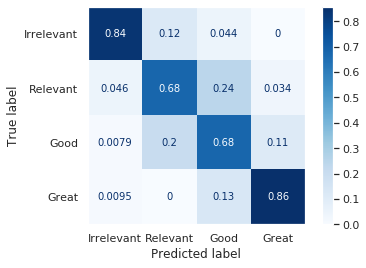

In [0]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(chosen_clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true');
plt.grid(None)

The light corners indicate that most misclassification is happening just up or down one level, not from one end of the scale (0) to another (3). We see the most misclassification between the levels 1 and 2, the middle classes. Our hypothesis is that these classes are not easily distinguished, even for human raters, and therefore perhaps the rubric and rating scale needs to be adjusted. Alternatively, there might be other features we can examine to help distinguish between those cases.

### Inter-Rater Reliability
When two or more people rate samples, it is useful to see how well they agree. This can be computed using the metric inter-rater reliability, and one version of it involves computing Cohen's Kappa \[6\]. For reference, when two humans applied the same rubric to this dataset, they recieved a weighted Cohen's Kappa of 0.76, which can be interpreted as substantial agreement.

In [0]:
from sklearn.metrics import cohen_kappa_score
print("Weighted Cohen's Kappa =", cohen_kappa_score(y_test, y_pred, weights='linear'))

Weighted Cohen's Kappa = 0.7682901554404146


This result indicates our classifier has about as much agreement with a human set of quality ratings as other human raters do.

## Feature Importance

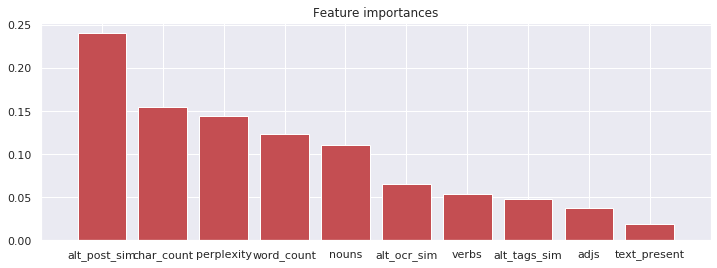

In [0]:
import matplotlib.pyplot as plt
feature_names = ['alt_tags_sim', 'alt_post_sim', 'alt_ocr_sim', 'verbs', 'adjs', 'nouns', 'word_count', 'char_count', 'perplexity','text_present']
importances = pd.DataFrame(chosen_clf.feature_importances_,
                                   index = feature_names,
                                   columns=['importance'])
order = importances['importance'].sort_values(ascending=False)
plt.figure(figsize=(12,4))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances.loc[order.index]['importance'],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), order.index)
plt.xlim([-1, X.shape[1]])
plt.show()

The similarity between the post text and the alt text is the highest feature, with almost 25% of the importance. Next we have character count, and word count is #4, both are proxies for length. Perplexity ranks high as well as the percent of nouns, these are proxies for structure and coverage of objects in the alt text.

## Examining Misclassifications
First we examine the egregious case where the classifier was on the entire wrong side of the scale.

In [0]:
errors = abs((y_test - y_pred).astype(int)) # how far off the classifier was
idxs = pd.Index(np.array(idx_test)[(errors == 3)])
rows = df_w_text.loc[idxs]
rows

,,sample_name,author_screenname,author_userid,post_text,image_url,alt_text,quality_rating,perplexity,text,tags,text_and_tags
tweet_id,image_index,,,,,,,,,,,
1014381132639555584,0,sample_3_no_bots,mylittlefinger,17963349,Leafbird hiding in leaves. https://t.co/IcCO05...,http://pbs.twimg.com/media/DhPODPRWsAA6OQl.jpg,Leafbird hiding in leaves.,3,211.850176,,,


In [0]:
Image(url=rows.loc[idxs[0], 'image_url'])

The tweet has been deleted. That lead to no tags or text being found in the image, which could be why it was not rated highly.

Let's move on to images where the classifier was only two levels off.

In [0]:
idxs = pd.Index(np.array(idx_test)[(errors == 2)])
rows = df_w_text.loc[idxs]
rows[['image_url', 'alt_text','text','tags','perplexity', 'quality_rating']]

,,image_url,alt_text,text,tags,perplexity,quality_rating
tweet_id,image_index,,,,,,
827249145576517632,0,http://pbs.twimg.com/media/C3r6RHMUYAAP0zj.jpg,"level rod in foreground, man on level gun in t...",746 5 443 2 1,dirt water people sign pole covered sitting sl...,515.495775,1
1031931873868439554,0,http://pbs.twimg.com/media/DlIokPuV4AANaO7.jpg,JESSIE TEAM ROCKET - POKEMON - JinxKittie Cos...,JINXKITTIE COSPLAY,hat woman water red board yellow white dressed...,452.865576,1
1032364240110215168,0,http://pbs.twimg.com/media/DlOxzelW4AAZWsf.png,You ALREADY GAVE ME THAT,,shirt person,61.941487,0
1007076180527341568,0,http://pbs.twimg.com/media/DfnacrbU0AAZxgm.png,@ibogost Members only. https://t.co/aWgBWasroV,,kite colorful various different Toy thing food...,1165.994168,0
1031661918099005441,0,http://pbs.twimg.com/media/DlEzC3WWsAE4bUK.png,recovery,,colorful sitting different traffic computer ha...,NaN,0
1018107618487951361,0,http://pbs.twimg.com/media/DiELev0XkAEnQlY.jpg,2000000km,"Pilot Earn 1,000,000 km across the distance of...",,NaN,2
742606443422068736,0,http://pbs.twimg.com/media/Ck5En4FUUAMfMzq.jpg,"Filling station and garage at Pie Town, New Me...",,people water street small large red building c...,370.354325,1


In [0]:
print('Post Text:', rows.loc[idxs[0], 'post_text'])
print('Recognizes Text:', rows.loc[idxs[0], 'text'])
print('Alt Text:', rows.loc[idxs[0], 'alt_text'])
print('Image Tags:', rows.loc[idxs[0], 'tags'])
Image(url=rows.loc[idxs[0], 'image_url'], width=200)

Post Text: Running levels this morning at 10311725 SIXMILE CYN CK AT HWY 50 NR DAYTON https://t.co/B8PFyR6vGM https://t.co/wVGPjs5w0l
Recognizes Text: 746 5 443 2 1
Alt Text: level rod in foreground, man on level gun in the background
Image Tags: dirt water people sign pole covered sitting slope outdoor snow grass holding air mountain person group hill standing man field riding skiing plane


The classifier gave this image a 3, and humans rated it a 1.  If we want to dig in deeper on this, we can use treeinterpreter to tell us how each feature changed the predictions for each class.

In [0]:
from treeinterpreter import treeinterpreter as ti
sample_idx = np.nonzero(errors==2)[0][0]
prediction, bias, contributions = ti.predict(chosen_clf, X_test[sample_idx, :].reshape(1, -1))
print("Class priors: \t\t", np.round(bias[0],2))
print("Predictions: \t\t", np.round(prediction[0],2))
print("Feature contributions:")
chosen = np.argmax(prediction)
for c, feature in zip(contributions[0], feature_names):
  print(feature, "\t\t", np.round(c,2))

Class priors: 		 [0.16 0.25 0.3  0.29]
Predictions: 		 [0.   0.04 0.24 0.72]
Feature contributions:
alt_tags_sim 		 [-0.   -0.   -0.01  0.01]
alt_post_sim 		 [-0.04 -0.07 -0.03  0.14]
alt_ocr_sim 		 [ 0.    0.03 -0.06  0.03]
verbs 		 [ 0.01  0.06  0.04 -0.1 ]
adjs 		 [ 0.    0.02  0.04 -0.06]
nouns 		 [-0.03 -0.11  0.03  0.11]
word_count 		 [-0.05 -0.05 -0.02  0.12]
char_count 		 [-0.03 -0.03 -0.05  0.11]
perplexity 		 [-0.03 -0.06  0.    0.09]
text_present 		 [ 0.   -0.    0.01 -0.01]


The biggest factors in increasing the probability of a 3 rating were: the alt text and post text similarity, and length. This alt text was long and somewhat similar to the post text, so it recieved a high rating.

Finally, let's look at the cases where it was only off by one level. 

In [0]:
idxs = pd.Index(np.array(idx_test)[(errors == 1)])
rows = df_w_text.loc[idxs]
rows[['image_url', 'alt_text','text','tags','perplexity', 'quality_rating']]

,,image_url,alt_text,text,tags,perplexity,quality_rating
tweet_id,image_index,,,,,,
998537671977861123,0,http://pbs.twimg.com/media/DduEuAaV4AA6GfF.jpg,"Cup of coffee, map, and notebook saying ""let's...","SHXVZVY - , ,",table indoor,44.450846,2
1032080460816547840,0,http://pbs.twimg.com/media/DlKvtV-X4AA1CzY.png,cartoon,,computer window room,NaN,0
1026914171613536257,0,http://pbs.twimg.com/media/DkBU-NsW0AE1sVF.jpg,Another pub called the Islington,"04. ra D/D/RR/ azag UPSE,"" RHYTHM • L/W/CS z i...",building text clock station bench hanging blac...,174.179212,1
967564628610965504,0,http://pbs.twimg.com/media/DW165mPX4AEWyL_.jpg,"FHA low income housing project. Holyoke, Massa...",,woman people house street small large sign bui...,1095.954624,2
969362911570354176,0,http://pbs.twimg.com/media/DXPebd6VAAA2H5p.jpg,Woman with arms reaching up to plane in air,,flying man water ocean sunset body boat blue l...,374.479518,2
...,...,...,...,...,...,...,...
1019427288587304961,0,http://pbs.twimg.com/media/DiW7tk1X4AAG9wX.png,screenshot from HeartCatch PreCure! ep.44 @ 11...,"Your turn, Desertrian!",,1058.389577,2
993612721533931521,0,http://pbs.twimg.com/media/DcoFgLjXUAEJk10.jpg,Hiking near Mt. Hood,,dirt trail wood sign red country tree forest s...,629.948870,1
976498453957128192,0,http://pbs.twimg.com/media/DY025_zV4AA-fN4.jpg,The Naked and Famous concert at Moroccan Loung...,,woman people laying sitting playing white youn...,307.651505,2


In [0]:
row = rows.loc[idxs[0]]
sample_idx = np.nonzero(errors==1)[0][0]
print('Post Text:',  row.post_text[0])
print('Recognized Text:', row.text[0])
print('Alt Text:', row.alt_text[0])
print('Image Tags:', row.tags[0])
print('Expected Rating: ', y_test[sample_idx], 'Predicted Rating:', y_pred[sample_idx])
Image(url=row.image_url[0], width=400)

Post Text: The seven cities where you can find the world's best coffee: https://t.co/oxPMr7L1Wj https://t.co/SunVcMudOB
Recognized Text: SHXVZVY - , ,
Alt Text: Cup of coffee, map, and notebook saying "let's go"
Image Tags: table indoor
Expected Rating:  2.0 Predicted Rating: 3.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


It does not seem unreasonable to give this a 3. That is likely the cases where the image and alt text inhabit a border area between classes. Perhaps they are not exactly a 2 or 3, or humans mislabelled them.

In [0]:
prediction, bias, contributions = ti.predict(chosen_clf, X_test[sample_idx, :].reshape(1, -1))
print("Class priors: \t\t", np.round(bias[0],2))
print("Predictions: \t\t", np.round(prediction[0],2))
print("Feature contributions:")
chosen = np.argmax(prediction)
for c, feature in zip(contributions[0], feature_names):
  print(feature, "\t\t", np.round(c,2))

Class priors: 		 [0.16 0.25 0.3  0.29]
Predictions: 		 [0.07 0.08 0.32 0.53]
Feature contributions:
alt_tags_sim 		 [ 0.01  0.01  0.02 -0.03]
alt_post_sim 		 [-0.05  0.03 -0.03  0.04]
alt_ocr_sim 		 [ 0.01  0.   -0.03  0.02]
verbs 		 [ 0.03 -0.02  0.04 -0.05]
adjs 		 [ 0.    0.01  0.01 -0.02]
nouns 		 [-0.01 -0.06 -0.01  0.08]
word_count 		 [-0.04 -0.03 -0.    0.07]
char_count 		 [-0.03 -0.01 -0.02  0.07]
perplexity 		 [-0.01 -0.1   0.04  0.07]
text_present 		 [ 0.    0.    0.01 -0.01]


The classifier only assigned 53% of probability to the 3 rating, and still had a significant probability given to the 2 rating. 

## Using the Classifier to Automatically Grade Alt Text

We now have our classifier trained, and we can use it to automatically grade new alt text.

Let's take a new image and try different alt texts:

In [0]:
def evaluate_alt_text(model, post_text, image_url, alt_text):
  text = get_text_in_image(image_url)
  tags = get_tags_and_objects(image_url)
  perplexity = gpt_perplexity(alt_text)
  if perplexity == None:
    perplexity = df_w_text['perplexity'].max()
  if text == None:
    text = ""
  print("Post text: ", post_text)
  print("Alt text: ", alt_text)
  print("Image tags: ", tags)
  print("Image text: ", text)
  X, _ = create_features([alt_text], [tags], [post_text], [text], [perplexity], scaler=scaler)
  return X,model.predict(X)[0]

image_url = "https://pbs.twimg.com/media/EF-l-ocVAAES7DW?format=jpg&name=medium"
post_text = """The dog being cute. Quite comfortable, thank you very much. 
Upside down on the only couch he's allowed on. He wants, err, no, DEMANDS, a tummy rub!"""
Image(url=image_url, width=400)

Ok, let's design some bad alt text. Most that look like this do not even describe the image. 

In [0]:
alt_text = "page"
feat, rating = evaluate_alt_text(chosen_clf, post_text, image_url, alt_text)
print("Rating: ", rating)
prediction, bias, contributions = ti.predict(chosen_clf, feat)
print("Class priors: \t\t", np.round(bias[0],2))
print("Predictions: \t\t", np.round(prediction[0],2))
print("Feature contributions:")
chosen = np.argmax(prediction)
for c, feature in zip(contributions[0], feature_names):
  print(feature, "\t\t", np.round(c,2))

Post text:  The dog being cute. Quite comfortable, thank you very much. 
Upside down on the only couch he's allowed on. He wants, err, no, DEMANDS, a tummy rub!
Alt text:  page
Image tags:  dog indoor lying looking black bed wearing white laying head brown small sitting
Image text:  
Rating:  1.0
Class priors: 		 [0.16 0.25 0.3  0.29]
Predictions: 		 [0.   0.94 0.06 0.  ]
Feature contributions:
alt_tags_sim 		 [-0.   -0.02  0.03  0.  ]
alt_post_sim 		 [-0.23  0.21  0.01  0.01]
alt_ocr_sim 		 [-0.01  0.02 -0.   -0.  ]
verbs 		 [ 0.    0.02 -0.   -0.02]
adjs 		 [-0.    0.01 -0.   -0.  ]
nouns 		 [-0.08  0.08 -0.    0.  ]
word_count 		 [ 0.08  0.07 -0.05 -0.1 ]
char_count 		 [ 0.    0.18 -0.1  -0.08]
perplexity 		 [ 0.1   0.12 -0.12 -0.1 ]
text_present 		 [-0.02  0.02  0.    0.  ]


Unfortunately, we were attempting to get a rating of 0, but 1 is pretty low as well. Let's try some "good" alt text

In [0]:
alt_text = "my cute dog"
feat, rating = evaluate_alt_text(chosen_clf, post_text, image_url, alt_text)
print("Rating: ", rating)

Post text:  The dog being cute. Quite comfortable, thank you very much. 
Upside down on the only couch he's allowed on. He wants, err, no, DEMANDS, a tummy rub!
Alt text:  my cute dog
Image tags:  indoor wearing black looking brown dog small white lying head laying bed sitting
Image text:  
Rating:  2.0


The classifier's rating looks good.
Let's try some "Great" alt text, which is the original alt text associated with this image on Twitter:

In [0]:
alt_text = "Close up of a black dog's face with both front paws bent over."
feat, rating = evaluate_alt_text(chosen_clf, post_text, image_url, alt_text)
print("Rating: ", rating)

Post text:  The dog being cute. Quite comfortable, thank you very much. 
Upside down on the only couch he's allowed on. He wants, err, no, DEMANDS, a tummy rub!
Alt text:  Close up of a black dog's face with both front paws bent over.
Image tags:  indoor wearing black looking brown dog small white lying head laying bed sitting
Image text:  
Rating:  3.0


The classifier's rating is correct. So this demonstrates how one could utilize this classifier in the future to grade alt text, either to choose the best from a pool or to give feedback.

### More Examples
Here are some additional examples that should all be rated as 3, and the classifier rates them correctly.

In [0]:
alt_text = "A white CMU HCII 25th anniversary banner hangs on a pole outside of Newell-Simon Hall at Carnegie Mellon University. Clear blue skies above."
image_url = "https://pbs.twimg.com/media/EFUwzNsWwAEa3mJ?format=jpg&name=small"
post_text = "Planning to join us for #hcii25 next month? RSVP today so we can count you in! Join us for 3 interactive panel presentations, lots of #cmuhcii lab tours, happy hour @thewarholmuseum, food, fun and more! Details & RSVP link: https://. See you there!"
feat, rating = evaluate_alt_text(chosen_clf, post_text, image_url, alt_text)
print("Rating: ", rating)
Image(url=image_url, width=400)

Post text:  Planning to join us for #hcii25 next month? RSVP today so we can count you in! Join us for 3 interactive panel presentations, lots of #cmuhcii lab tours, happy hour @thewarholmuseum, food, fun and more! Details & RSVP link: https://. See you there!
Alt text:  A white CMU HCII 25th anniversary banner hangs on a pole outside of Newell-Simon Hall at Carnegie Mellon University. Clear blue skies above.
Image tags:  tree pole Billboard outdoor dormer window large sitting house text red building parked sign people city parking stop hanging white front street traffic side tall window post
Image text:  HCII HUMAN-COMPUTER
Rating:  3.0


In [0]:
alt_text = "Jeff wearing sequent calculus shirt, drinking champagne in big first class seat"
image_url = "https://pbs.twimg.com/media/EEaUnjUWsAELyc9?format=jpg&name=medium"
post_text = "sequent calculus got fancy, cheers to @justinesherry for the t-shirt that keeps on giving, cheers to @delta for the global upgrade certificates, cheers to @jenbigham for putting up with all my flying... so many cheers, I'm going to need more champagne"
feat, rating = evaluate_alt_text(chosen_clf, post_text, image_url, alt_text)
print("Rating: ", rating)
Image(url=image_url, width=200)

Post text:  sequent calculus got fancy, cheers to @justinesherry for the t-shirt that keeps on giving, cheers to @delta for the global upgrade certificates, cheers to @jenbigham for putting up with all my flying... so many cheers, I'm going to need more champagne
Alt text:  Jeff wearing sequent calculus shirt, drinking champagne in big first class seat
Image tags:  person indoor wearing man standing seat train bus woman truck holding luggage white car large young blue sitting plane
Image text:  Pi
Rating:  3.0


## Discussion and Future Work
We have developed a classifier that can automatically grade alternative text with 75% accuracy. The most straightforward application of our project is to provide users with on-the-fly feedback about how to draft a better description to the pictures they posted. 
The classifier not only can provide a rating (which could be turned into an indicator similar to "password strength" metrics), but also the feature contributions can be used to detail specifically what to improve. For example:

*   If char_count or word_count are shifting probability mass to low ratings, say "Try writing some more! Longer alt text tends to be more descriptive!"
*   If "alt_tags_sim" is moving probability mass to low ratings, say "We see some more things in the image that could be described! What does the dog look like?"

One limitation with this work is the quality-ratings in the dataset. Many of the edge-cases may be mislabelled by humans, or they do not clearly belong to a single class. In addition, these images and alt text pairs were rated by sighted researchers, and their notions of quality may not reflect what people with vision impairments desire. 

Future work should examine how to validate this quality scale with visually impaired Twitter users. Additionally, future uses of a dataset like this should validate the ratings among many human raters, and perhaps take the most common rating or further investigate samples where raters cannot agree.

Another future investigation could be extracting more features from image, such as face recognition of celebrities, which could help rate those alt text containing celebrities’ names.


## References

1.   Tim Berners-Lee and Daniel Connelly. 1995. [Hypertext Markup Language – 2.0](https://tools.ietf.org/html/rfc1866). Internet Engineering Task Force. RFC 1866.
2.   Jeffrey P Bigham, Ryan S Kaminsky, Richard E Ladner, Oscar M Danielsson, and Gordon L Hempton. 2006. WebInSight: Making Web Images Accessible. In Proceedings of the 8th international ACM SIGACCESS conference on Computers and accessibility - Assets ’06.
3.   Guinness, D., Cutrell, E., & Morris M.R. (2018, May). [Caption Crawler: Enabling Reusable Alternative Text Descriptions Using Reverse Image Search.](https://dl.acm.org/citation.cfm?id=3174092) In Proceedings of the 2018 CHI Conference on Human Factors in Computing Systems. ACM
4.   Meredith Ringel Morris, Annuska Zolyomi, Catherine Yao, Sina Bahram, Jeffrey P. Bigham, and Shaun K. Kane. 2016. ["With most of it being pictures now, I rarely use it": Understanding Twitter's Evolving Accessibility to Blind Users](https://dl.acm.org/citation.cfm?id=2858116). In Proceedings of the 2016 CHI Conference on Human Factors in Computing Systems (CHI '16).
5.   Cole Gleason, Patrick Carrington, Cameron Cassidy, Meredith Ringel Morris, Kris M. Kitani, and Jeffrey P. Bigham. 2019. [“It's almost like they're trying to hide it”: How User-Provided Image Descriptions Have Failed to Make Twitter Accessible](https://dl.acm.org/citation.cfm?id=3313605). In The World Wide Web Conference (WWW '19).
6. McHugh, Mary L. [Interrater reliability: the kappa statistic](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900052/). Biochemia medica vol. 22,3 (2012).
